In [1]:
import os
import re
import time
import torch
import random
import numpy as np
from tqdm import tqdm

from sklearn.utils import shuffle
from json_tools import load_json, dump_json
from transformers import BertTokenizer
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc
from torch.utils.tensorboard import SummaryWriter  
from sklearn.model_selection import train_test_split
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# load data

In [2]:

datas = load_json("ps_sents_pair_with_label.json")

In [3]:
#shuffle datas
datas = shuffle(shuffle(datas,random_state=22),random_state=22)

In [4]:
train,test = train_test_split(datas,test_size=0.2, random_state=2022)
test,val = train_test_split(test,test_size=0.5, random_state=2022)

In [5]:
train[0]

{'sent1': "These achievements combined with academic progress resulted in the honour of signing the Head Teacher's Book, thirteen times.",
 'sent2': 'Since then I have been determined to not only help people in pain, I want to have the independence of making my own decisions and building friendly relationships with my clients.',
 'label': 0}

In [6]:
train1,train0,test1,test0,val1,val0=0,0,0,0,0,0


In [7]:
len(train),len(test),len(val)

(26870, 3359, 3359)

# Load the BERT tokenizer

In [8]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True,cache_dir=os.path.join(os.getcwd(),"bert-base-uncased_cache"))


# find the maximum length

In [9]:

sents1 = [d["sent1"].lower() for d in datas]
sents2 = [d["sent2"].lower() for d in datas]
sents = list(set(sents1+sents2))
# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in sents]
# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  141


In [10]:
# specify a MAX_LEN you like
MAX_LEN=150

In [11]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# set device

In [12]:
def get_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print(f'There are {torch.cuda.device_count()} GPU(s) available.')
        print('Device name:', torch.cuda.get_device_name(0))

    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")
    return device
device = get_device()

No GPU available, using the CPU instead.


# Create a function to tokenize a set of texts

In [13]:

def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent["sent1"].lower()),#The first sequence to be encoded
            text_pair=text_preprocessing(sent["sent2"].lower()),# second sequence to be encoded
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
#             return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [14]:
#Convert  labels to torch.Tensor
train_labels = torch.tensor([t["label"] for t in train])
test_labels = torch.tensor([t["label"] for t in test])
val_labels = torch.tensor([t["label"] for t in val])
train_labels,test_labels,val_labels

(tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [15]:
torch.count_nonzero(train_labels).item(),len(train_labels)-torch.count_nonzero(train_labels).item()

(5589, 21281)

In [16]:
torch.count_nonzero(test_labels).item(),len(test_labels)-torch.count_nonzero(test_labels).item()

(682, 2677)

In [17]:
torch.count_nonzero(val_labels).item(),len(val_labels)-torch.count_nonzero(val_labels).item()

(721, 2638)

In [18]:
# 
train_inputs, train_masks = preprocessing_for_bert(train)
test_inputs, test_masks = preprocessing_for_bert(test)
val_inputs, val_masks = preprocessing_for_bert(val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Create PyTorch DataLoader

In [19]:
#Create PyTorch DataLoader

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 4

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create BertClassifier

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the [CLS] token is used as the features of the sequence to feed a classifier.

The transformers library has the BertForSequenceClassification class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the [CLS] token and a single-hidden-layer feed-forward neural network as our classifier.

In [20]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 128, 2
        unfreeze_layers = ['layer.10','layer.11','bert.pooler','out.']
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased',cache_dir=os.path.join(os.getcwd(),"bert-base-uncased_cache"))

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
#             nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
#             for name, param in self.bert.named_parameters():
#                 print(name,param.size())
 
#             print("*"*30)
#             print('\n')
 
            for name ,param in self.bert.named_parameters():
                param.requires_grad = False
                for ele in unfreeze_layers:
                    if ele in name:
                        param.requires_grad = True
                        break
#             #验证一下
#             for name, param in self.bert.named_parameters():
#                 if param.requires_grad:
#                     print(name,param.size())

        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Wall time: 2.99 ms


# Optimizer & Learning Rate Scheduler

recommend following hyper-parameters
   - Batch size: 16 or 32       
   - Learning rate (Adam): 5e-5, 3e-5 or 2e-5  
   - Number of epochs: 2, 3, 4  

In [21]:
len_train_step = len(train_dataloader)
print('len_train_step: ',len_train_step)

def initialize_model(epochs=5,fp16=False,n_gpu=0,local_rank=-1):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=True)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=1e-7,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len_train_step * epochs
    warm_up_ratio = 1.0 # 定义要预热的step
    # Set up the learning rate scheduler
    # https://blog.csdn.net/orangerfun/article/details/120400247
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=warm_up_ratio*total_steps, # Default value
                                                num_training_steps=total_steps)
    #### Optional configuration
#     if fp16:"Whether to use 16-bit (mixed) precision (through NVIDIA apex) instead of 32-bit"
#         try:
#             from apex import amp
#             fp16_opt_level = '01'
#         except ImportError:
#             raise ImportError("Please install apex from "
#             "https://www.github.com/nvidia/apex to use fp16 training.")
#         bert_classifier, optimizer = amp.initialize(
#             bert_classifier, optimizer, opt_level=fp16_opt_level)
#         "For fp16: Apex AMP optimization level "
#         "selected in ['O0', 'O1', 'O2', and 'O3']."
#         "See details at https://nvidia.github.io/apex/amp.html"
#     # multi-gpu training (should be after apex fp16 initialization)
#     if n_gpu > 1:
#         bert_classifier = torch.nn.DataParallel(bert_classifier)
        
#      # Distributed training (should be after apex fp16 initialization)
#     if local_rank != -1:
#         bert_classifier = torch.nn.parallel.DistributedDataParallel(
#             bert_classifier, 
#             device_ids=[local_rank],
#             output_device=local_rank,
#             find_unused_parameters=True
#             )
        
    return bert_classifier, optimizer, scheduler


len_train_step:  6718


# Training Loop

Training:

- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (loss.backward())
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (optimizer.step())
- Update the learning rate (scheduler.step())

Evaluation:

- Unpack our data and load onto the GPU
- Forward pass
- Compute loss and accuracy rate over the validation set

In [22]:
writer = SummaryWriter('./log/lr=1e-7droupout=0.0warmup=1.0batchsize=4')

In [23]:
# Specify loss function
# loss_fn = nn.CrossEntropyLoss(reduction='mean',label_smoothing=0.05)
loss_fn = nn.CrossEntropyLoss(reduction='mean')
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    one_cricle_length = len(train_dataloader)
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed/lr':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)
            #print('logits,b_labels')
            #print(logits)
            #print(b_labels)
            '''tensor([[-0.0491,  0.1918],
                       [-0.0062,  0.1743],
                       [-0.0856,  0.2257],
                       [-0.0044,  0.1629]], grad_fn=<AddmmBackward>)
                tensor([0, 1, 0, 0])
            '''
            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            #print(loss)
            #print(logits.shape,b_labels.shape,loss.shape)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()
#             b = 0.64
#             flood = (loss-b).abs()+b
#             flood.backward()
            
            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients",L2 norm fuc
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0, norm_type=2)

            # Update parameters and the learning rate
            op_params =optimizer.state_dict()['param_groups'][0]
            lr = op_params.get('lr')
            
            ########################################################################
            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                writer.add_scalar('step/train_loss_step', batch_loss / batch_counts, step + epoch_i*one_cricle_length)
                writer.add_scalar('step/train_lr_step', lr, step + epoch_i*one_cricle_length)

                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
#                 writer.add_scalar('steploss/train_loss_step', batch_loss / batch_counts, step)
                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {lr}")
                
                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
            ###############################################################
            optimizer.step()
            scheduler.step()
        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_f1 = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            writer.add_scalar('lr=1e-7droupout=0.0warmup=1.0batchsize=4/train_loss', avg_train_loss, epoch_i)
            writer.add_scalar('lr=1e-7droupout=0.0warmup=1.0batchsize=4/val_loss', val_loss, epoch_i)
            writer.add_scalar('step/val_f1', val_f1, epoch_i)
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_f1:^9.2f} | {time_elapsed:^15.6f}")
            print("-"*70)
        print("\n")
    writer.close()
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []
    val_f1 = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        # accuracy = (preds == b_labels).cpu().numpy().mean() * 100
#         accuracy = (preds == b_labels).cpu().numpy().mean()
        f1 = f1_score(b_labels, preds, average='weighted')
        val_f1.append(f1)
#         val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_f1 = np.mean(val_f1)

    return val_loss, val_f1

# running

In [24]:
epochs=5
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=epochs)
train(bert_classifier, train_dataloader, val_dataloader, epochs=epochs, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  | Elapsed/lr
----------------------------------------------------------------------
   1    |   20    |   0.761838   |     -      |     -     | 5.954153021732658e-11
   1    |   40    |   0.763381   |     -      |     -     | 1.1908306043465317e-10
   1    |   60    |   0.777204   |     -      |     -     | 1.7862459065197975e-10
   1    |   80    |   0.765129   |     -      |     -     | 2.3816612086930634e-10
   1    |   100   |   0.750455   |     -      |     -     | 2.977076510866329e-10
   1    |   120   |   0.755798   |     -      |     -     | 3.572491813039595e-10
   1    |   140   |   0.748982   |     -      |     -     | 4.167907115212861e-10
   1    |   160   |   0.762940   |     -      |     -     | 4.763322417386127e-10
   1    |   180   |   0.765499   |     -      |     -     | 5.358737719559393e-10
   1    |   200   |   0.765553   |     -      |     -     | 5.954153021732658e-10
   1    |   220 

   1    |  1980   |   0.743212   |     -      |     -     | 5.894611491515332e-09
   1    |  2000   |   0.753924   |     -      |     -     | 5.954153021732658e-09
   1    |  2020   |   0.753358   |     -      |     -     | 6.013694551949984e-09
   1    |  2040   |   0.765512   |     -      |     -     | 6.073236082167311e-09
   1    |  2060   |   0.756982   |     -      |     -     | 6.132777612384638e-09
   1    |  2080   |   0.742692   |     -      |     -     | 6.192319142601964e-09
   1    |  2100   |   0.767772   |     -      |     -     | 6.251860672819291e-09
   1    |  2120   |   0.756742   |     -      |     -     | 6.3114022030366175e-09
   1    |  2140   |   0.760362   |     -      |     -     | 6.370943733253944e-09
   1    |  2160   |   0.756786   |     -      |     -     | 6.43048526347127e-09
   1    |  2180   |   0.738895   |     -      |     -     | 6.490026793688598e-09
   1    |  2200   |   0.765729   |     -      |     -     | 6.549568323905924e-09
   1    |  2220 

   1    |  3980   |   0.726876   |     -      |     -     | 1.1848764513247989e-08
   1    |  4000   |   0.743495   |     -      |     -     | 1.1908306043465317e-08
   1    |  4020   |   0.756381   |     -      |     -     | 1.1967847573682643e-08
   1    |  4040   |   0.743200   |     -      |     -     | 1.2027389103899969e-08
   1    |  4060   |   0.750248   |     -      |     -     | 1.2086930634117296e-08
   1    |  4080   |   0.756163   |     -      |     -     | 1.2146472164334622e-08
   1    |  4100   |   0.742078   |     -      |     -     | 1.2206013694551948e-08
   1    |  4120   |   0.753060   |     -      |     -     | 1.2265555224769276e-08
   1    |  4140   |   0.732322   |     -      |     -     | 1.2325096754986602e-08
   1    |  4160   |   0.740694   |     -      |     -     | 1.2384638285203928e-08
   1    |  4180   |   0.727034   |     -      |     -     | 1.2444179815421255e-08
   1    |  4200   |   0.750761   |     -      |     -     | 1.2503721345638581e-08
   1

   1    |  5960   |   0.722872   |     -      |     -     | 1.7743376004763322e-08
   1    |  5980   |   0.719995   |     -      |     -     | 1.780291753498065e-08
   1    |  6000   |   0.718312   |     -      |     -     | 1.7862459065197974e-08
   1    |  6020   |   0.717846   |     -      |     -     | 1.7922000595415302e-08
   1    |  6040   |   0.713105   |     -      |     -     | 1.798154212563263e-08
   1    |  6060   |   0.714853   |     -      |     -     | 1.8041083655849954e-08
   1    |  6080   |   0.711087   |     -      |     -     | 1.810062518606728e-08
   1    |  6100   |   0.708858   |     -      |     -     | 1.816016671628461e-08
   1    |  6120   |   0.713875   |     -      |     -     | 1.8219708246501933e-08
   1    |  6140   |   0.719308   |     -      |     -     | 1.827924977671926e-08
   1    |  6160   |   0.715641   |     -      |     -     | 1.833879130693659e-08
   1    |  6180   |   0.712287   |     -      |     -     | 1.8398332837153916e-08
   1    | 

   2    |  1140   |   0.690652   |     -      |     -     | 2.3393867222387615e-08
   2    |  1160   |   0.691198   |     -      |     -     | 2.3453408752604943e-08
   2    |  1180   |   0.690859   |     -      |     -     | 2.3512950282822267e-08
   2    |  1200   |   0.686920   |     -      |     -     | 2.3572491813039595e-08
   2    |  1220   |   0.685385   |     -      |     -     | 2.3632033343256922e-08
   2    |  1240   |   0.685040   |     -      |     -     | 2.3691574873474247e-08
   2    |  1260   |   0.682766   |     -      |     -     | 2.3751116403691574e-08
   2    |  1280   |   0.686165   |     -      |     -     | 2.3810657933908902e-08
   2    |  1300   |   0.691551   |     -      |     -     | 2.387019946412623e-08
   2    |  1320   |   0.683143   |     -      |     -     | 2.3929740994343554e-08
   2    |  1340   |   0.692269   |     -      |     -     | 2.398928252456088e-08
   2    |  1360   |   0.685624   |     -      |     -     | 2.404882405477821e-08
   2   

   2    |  3140   |   0.655610   |     -      |     -     | 2.9348020244120274e-08
   2    |  3160   |   0.666801   |     -      |     -     | 2.94075617743376e-08
   2    |  3180   |   0.658933   |     -      |     -     | 2.9467103304554923e-08
   2    |  3200   |   0.657404   |     -      |     -     | 2.952664483477225e-08
   2    |  3220   |   0.655705   |     -      |     -     | 2.9586186364989578e-08
   2    |  3240   |   0.658322   |     -      |     -     | 2.9645727895206906e-08
   2    |  3260   |   0.654978   |     -      |     -     | 2.9705269425424233e-08
   2    |  3280   |   0.651319   |     -      |     -     | 2.9764810955641558e-08
   2    |  3300   |   0.655404   |     -      |     -     | 2.982435248585888e-08
   2    |  3320   |   0.660340   |     -      |     -     | 2.988389401607621e-08
   2    |  3340   |   0.653212   |     -      |     -     | 2.994343554629354e-08
   2    |  3360   |   0.661655   |     -      |     -     | 3.000297707651087e-08
   2    |  

   2    |  5140   |   0.598674   |     -      |     -     | 3.530217326585293e-08
   2    |  5160   |   0.599343   |     -      |     -     | 3.5361714796070255e-08
   2    |  5180   |   0.629508   |     -      |     -     | 3.5421256326287585e-08
   2    |  5200   |   0.625218   |     -      |     -     | 3.548079785650491e-08
   2    |  5220   |   0.649402   |     -      |     -     | 3.5540339386722234e-08
   2    |  5240   |   0.626845   |     -      |     -     | 3.5599880916939565e-08
   2    |  5260   |   0.637722   |     -      |     -     | 3.565942244715689e-08
   2    |  5280   |   0.648517   |     -      |     -     | 3.5718963977374214e-08
   2    |  5300   |   0.627231   |     -      |     -     | 3.5778505507591545e-08
   2    |  5320   |   0.604603   |     -      |     -     | 3.583804703780887e-08
   2    |  5340   |   0.621902   |     -      |     -     | 3.58975885680262e-08
   2    |  5360   |   0.625835   |     -      |     -     | 3.5957130098243524e-08
   2    | 

   3    |   340   |   0.598195   |     -      |     -     | 4.101220601369455e-08
   3    |   360   |   0.588915   |     -      |     -     | 4.107174754391188e-08
   3    |   380   |   0.622024   |     -      |     -     | 4.11312890741292e-08
   3    |   400   |   0.600606   |     -      |     -     | 4.1190830604346533e-08
   3    |   420   |   0.587670   |     -      |     -     | 4.125037213456386e-08
   3    |   440   |   0.635982   |     -      |     -     | 4.130991366478118e-08
   3    |   460   |   0.583226   |     -      |     -     | 4.1369455194998506e-08
   3    |   480   |   0.606755   |     -      |     -     | 4.142899672521584e-08
   3    |   500   |   0.596941   |     -      |     -     | 4.148853825543316e-08
   3    |   520   |   0.588889   |     -      |     -     | 4.154807978565049e-08
   3    |   540   |   0.557798   |     -      |     -     | 4.160762131586782e-08
   3    |   560   |   0.564378   |     -      |     -     | 4.166716284608514e-08
   3    |   580

   3    |  2340   |   0.591511   |     -      |     -     | 4.696635903542721e-08
   3    |  2360   |   0.608679   |     -      |     -     | 4.7025900565644534e-08
   3    |  2380   |   0.572824   |     -      |     -     | 4.708544209586186e-08
   3    |  2400   |   0.520306   |     -      |     -     | 4.714498362607919e-08
   3    |  2420   |   0.579902   |     -      |     -     | 4.7204525156296514e-08
   3    |  2440   |   0.579787   |     -      |     -     | 4.7264066686513844e-08
   3    |  2460   |   0.568059   |     -      |     -     | 4.732360821673117e-08
   3    |  2480   |   0.591138   |     -      |     -     | 4.738314974694849e-08
   3    |  2500   |   0.589074   |     -      |     -     | 4.744269127716582e-08
   3    |  2520   |   0.582027   |     -      |     -     | 4.750223280738315e-08
   3    |  2540   |   0.583433   |     -      |     -     | 4.756177433760047e-08
   3    |  2560   |   0.571069   |     -      |     -     | 4.7621315867817804e-08
   3    |  2

   3    |  4340   |   0.529811   |     -      |     -     | 5.292051205715987e-08
   3    |  4360   |   0.486969   |     -      |     -     | 5.2980053587377197e-08
   3    |  4380   |   0.517000   |     -      |     -     | 5.3039595117594514e-08
   3    |  4400   |   0.516242   |     -      |     -     | 5.309913664781185e-08
   3    |  4420   |   0.532790   |     -      |     -     | 5.315867817802917e-08
   3    |  4440   |   0.534856   |     -      |     -     | 5.32182197082465e-08
   3    |  4460   |   0.517188   |     -      |     -     | 5.3277761238463825e-08
   3    |  4480   |   0.478767   |     -      |     -     | 5.333730276868115e-08
   3    |  4500   |   0.618580   |     -      |     -     | 5.339684429889848e-08
   3    |  4520   |   0.523129   |     -      |     -     | 5.3456385829115804e-08
   3    |  4540   |   0.545000   |     -      |     -     | 5.3515927359333135e-08
   3    |  4560   |   0.525479   |     -      |     -     | 5.357546888955046e-08
   3    |  4

   3    |  6340   |   0.536800   |     -      |     -     | 5.887466507889253e-08
   3    |  6360   |   0.478556   |     -      |     -     | 5.8934206609109846e-08
   3    |  6380   |   0.473295   |     -      |     -     | 5.8993748139327183e-08
   3    |  6400   |   0.528502   |     -      |     -     | 5.90532896695445e-08
   3    |  6420   |   0.447790   |     -      |     -     | 5.911283119976184e-08
   3    |  6440   |   0.488098   |     -      |     -     | 5.9172372729979156e-08
   3    |  6460   |   0.462355   |     -      |     -     | 5.923191426019648e-08
   3    |  6480   |   0.530431   |     -      |     -     | 5.929145579041381e-08
   3    |  6500   |   0.521104   |     -      |     -     | 5.9350997320631136e-08
   3    |  6520   |   0.469051   |     -      |     -     | 5.941053885084847e-08
   3    |  6540   |   0.458203   |     -      |     -     | 5.947008038106579e-08
   3    |  6560   |   0.554364   |     -      |     -     | 5.9529621911283115e-08
   3    |  6

   4    |  1540   |   0.472584   |     -      |     -     | 6.458469782673415e-08
   4    |  1560   |   0.502089   |     -      |     -     | 6.464423935695146e-08
   4    |  1580   |   0.496698   |     -      |     -     | 6.47037808871688e-08
   4    |  1600   |   0.633356   |     -      |     -     | 6.476332241738612e-08
   4    |  1620   |   0.431381   |     -      |     -     | 6.482286394760345e-08
   4    |  1640   |   0.476434   |     -      |     -     | 6.488240547782077e-08
   4    |  1660   |   0.453705   |     -      |     -     | 6.49419470080381e-08
   4    |  1680   |   0.446203   |     -      |     -     | 6.500148853825544e-08
   4    |  1700   |   0.388415   |     -      |     -     | 6.506103006847276e-08
   4    |  1720   |   0.507982   |     -      |     -     | 6.512057159869008e-08
   4    |  1740   |   0.432901   |     -      |     -     | 6.518011312890741e-08
   4    |  1760   |   0.508150   |     -      |     -     | 6.523965465912473e-08
   4    |  1780   

   4    |  3560   |   0.527954   |     -      |     -     | 7.059839237868412e-08
   4    |  3580   |   0.529455   |     -      |     -     | 7.065793390890146e-08
   4    |  3600   |   0.578619   |     -      |     -     | 7.071747543911878e-08
   4    |  3620   |   0.465182   |     -      |     -     | 7.077701696933612e-08
   4    |  3640   |   0.489254   |     -      |     -     | 7.083655849955343e-08
   4    |  3660   |   0.502124   |     -      |     -     | 7.089610002977077e-08
   4    |  3680   |   0.421863   |     -      |     -     | 7.095564155998809e-08
   4    |  3700   |   0.527064   |     -      |     -     | 7.101518309020542e-08
   4    |  3720   |   0.461347   |     -      |     -     | 7.107472462042274e-08
   4    |  3740   |   0.442379   |     -      |     -     | 7.113426615064006e-08
   4    |  3760   |   0.530154   |     -      |     -     | 7.11938076808574e-08
   4    |  3780   |   0.537930   |     -      |     -     | 7.125334921107473e-08
   4    |  3800  

   4    |  5580   |   0.511454   |     -      |     -     | 7.661208693063411e-08
   4    |  5600   |   0.490798   |     -      |     -     | 7.667162846085145e-08
   4    |  5620   |   0.500980   |     -      |     -     | 7.673116999106876e-08
   4    |  5640   |   0.527470   |     -      |     -     | 7.679071152128609e-08
   4    |  5660   |   0.476753   |     -      |     -     | 7.685025305150342e-08
   4    |  5680   |   0.473881   |     -      |     -     | 7.690979458172075e-08
   4    |  5700   |   0.522766   |     -      |     -     | 7.696933611193807e-08
   4    |  5720   |   0.508526   |     -      |     -     | 7.70288776421554e-08
   4    |  5740   |   0.444551   |     -      |     -     | 7.708841917237273e-08
   4    |  5760   |   0.444249   |     -      |     -     | 7.714796070259006e-08
   4    |  5780   |   0.453660   |     -      |     -     | 7.720750223280738e-08
   4    |  5800   |   0.519200   |     -      |     -     | 7.72670437630247e-08
   4    |  5820   

   5    |   780   |   0.448934   |     -      |     -     | 8.232211967847573e-08
   5    |   800   |   0.317601   |     -      |     -     | 8.238166120869307e-08
   5    |   820   |   0.538337   |     -      |     -     | 8.244120273891039e-08
   5    |   840   |   0.522666   |     -      |     -     | 8.250074426912772e-08
   5    |   860   |   0.516403   |     -      |     -     | 8.256028579934504e-08
   5    |   880   |   0.429363   |     -      |     -     | 8.261982732956236e-08
   5    |   900   |   0.537841   |     -      |     -     | 8.26793688597797e-08
   5    |   920   |   0.415646   |     -      |     -     | 8.273891038999701e-08
   5    |   940   |   0.618622   |     -      |     -     | 8.279845192021434e-08
   5    |   960   |   0.452575   |     -      |     -     | 8.285799345043167e-08
   5    |   980   |   0.609317   |     -      |     -     | 8.2917534980649e-08
   5    |  1000   |   0.457717   |     -      |     -     | 8.297707651086632e-08
   5    |  1020   |

   5    |  2800   |   0.578778   |     -      |     -     | 8.833581423042572e-08
   5    |  2820   |   0.448691   |     -      |     -     | 8.839535576064305e-08
   5    |  2840   |   0.518026   |     -      |     -     | 8.845489729086037e-08
   5    |  2860   |   0.529940   |     -      |     -     | 8.85144388210777e-08
   5    |  2880   |   0.423789   |     -      |     -     | 8.857398035129502e-08
   5    |  2900   |   0.505195   |     -      |     -     | 8.863352188151236e-08
   5    |  2920   |   0.580684   |     -      |     -     | 8.869306341172967e-08
   5    |  2940   |   0.466602   |     -      |     -     | 8.8752604941947e-08
   5    |  2960   |   0.434547   |     -      |     -     | 8.881214647216433e-08
   5    |  2980   |   0.411307   |     -      |     -     | 8.887168800238167e-08
   5    |  3000   |   0.481116   |     -      |     -     | 8.893122953259898e-08
   5    |  3020   |   0.330492   |     -      |     -     | 8.89907710628163e-08
   5    |  3040   | 

   5    |  4820   |   0.548444   |     -      |     -     | 9.43495087823757e-08
   5    |  4840   |   0.367364   |     -      |     -     | 9.440905031259303e-08
   5    |  4860   |   0.616346   |     -      |     -     | 9.446859184281035e-08
   5    |  4880   |   0.448283   |     -      |     -     | 9.452813337302769e-08
   5    |  4900   |   0.525168   |     -      |     -     | 9.458767490324501e-08
   5    |  4920   |   0.453247   |     -      |     -     | 9.464721643346234e-08
   5    |  4940   |   0.509629   |     -      |     -     | 9.470675796367966e-08
   5    |  4960   |   0.536668   |     -      |     -     | 9.476629949389699e-08
   5    |  4980   |   0.528290   |     -      |     -     | 9.482584102411431e-08
   5    |  5000   |   0.548100   |     -      |     -     | 9.488538255433163e-08
   5    |  5020   |   0.532583   |     -      |     -     | 9.494492408454897e-08
   5    |  5040   |   0.429686   |     -      |     -     | 9.50044656147663e-08
   5    |  5060   

In [25]:

#saving a checkpoint assuming the network class named ClassNet
checkpoint={'modle':bert_classifier,
             'model_state_dict':bert_classifier.state_dict(),
             'optimize_state_dict':optimizer.state_dict(),
             'epoch':epochs}
torch.save(checkpoint,'checkoutpoints/checkpoint_epoch_10_lr_2e-7_dropout_0_warmupstep_0.0_seed_42.pkl')

In [27]:
def load_checkpoint(filepath,optimizer):
    checkpoint = torch.load(filepath)
    model=checkpoint['modle']#提前网络结构
    model.load_state_dict(checkpoint['model_state_dict'])#加载网络权重参数
    optimizer=optimizer
    optimizer.load_state_dict(checkpoint['optimize_state_dict'])#加载优化器参数
    for parameter in model.parameters():
        parameter.requires_grad=False
    model.eval()
    return model
modle=load_checkpoint('checkoutpoints/checkpoint_epoch_10_lr_2e-7_dropout_0_warmupstep_0.0_seed_42.pkl',optimizer)

# Evaluation on Validation Set

In [28]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [29]:
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc) 
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.5034
Accuracy: 79.70%


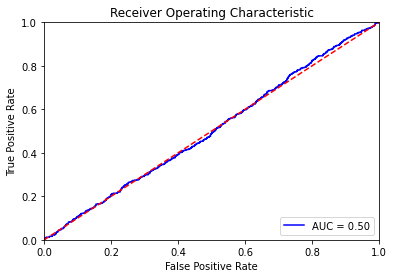

In [30]:
# Compute predicted probabilities on the test set
probs = bert_predict(modle, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, test_labels)